## This project use location data from multiple sources and demographics to create the shortlist for the new location of Japanese restaurant in Toronto
1. Unlike other medium - smaller cities in Canada there is plenty of data for city of Toronto available online
2. The high foot traffic based on popularity of the business venues is used as one of the selection criteria for location
3. The income, population and population density are also used to help with selection
4. The information related to 100 most commons venues will be obtained from foursquare

Setup to access data resources on IBM platform information will not visible to public users

In [1]:
# The code was removed by Watson Studio for sharing.

Downloading dependencies which are used for this projects

In [2]:
import numpy as np 
import pandas as pd 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!conda install -c conda-forge beautifulSoup4 --yes
!conda install -c conda-forge lxml --yes


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans
import requests 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from bs4 import BeautifulSoup



print('Completed importing libraries and  installation')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Completed importing libraries and  installation


Scrap Toronto postal code data from wikipedia using beautiful soup

In [3]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')
TNCode = soup.find('table',{'class':'wikitable sortable'})

Creating dataframe for Toronto postal code

In [4]:
columns=['Postcode','Borough','Neighbourhood']
df = pd.DataFrame(columns=columns)

for row in TNCode.findAll("tr"):
    trow=[]
    for cell in row.findAll("td"):
        trow.append(cell.text.strip())
        if len(trow)==3:
            df.loc[len(df)] = trow
print(df.shape)
df.head(15)

(288, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


Cleaning the data frame for Postal code because it has Not assigned neighbourhood and borough

In [5]:
df=df[df['Borough']!="Not assigned"]
df.loc[(df['Neighbourhood'] == 'Not assigned'), 'Neighbourhood'] = df['Borough']
df.reset_index(drop=True,inplace=True)
print(df.shape)
df.head(15)

(211, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [6]:
df1=df.sort_values('Neighbourhood')
df1.reset_index(drop=True, inplace=True)
df1.head()

,Postcode,Borough,Neighbourhood
0,M5H,Downtown Toronto,Adelaide
1,M1S,Scarborough,Agincourt
2,M1V,Scarborough,Agincourt North
3,M9V,Etobicoke,Albion Gardens
4,M8W,Etobicoke,Alderwood


Save the file to the object storage on ibm cloud, information is hidden to public users

In [7]:
# The code was removed by Watson Studio for sharing.

Completed saving the file to Object storage


Read file from object storage on ibm cloud

In [8]:
dfile = project.get_file("TorontoPostalCode2.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
dfile.seek(0)

dfu=pd.read_csv(dfile)
dfu1=dfu.sort_values('Neighbourhood')
dfu1.reset_index(drop=True,inplace=True)

In [9]:
dfu1.head()

,Postcode,Borough,Neighbourhood
0,M1V,Scarborough,Agincourt North
1,M1S,Scarborough,Agincourt South-Malvern West
2,M8W,Etobicoke,Alderwood
3,M5R,Central Toronto,Annex
4,M3B,North York,Banbury-Don Mills


Read csv file for Toronto neighbourhood profiles from open data Toronto website

In [10]:
df_TNDem=pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv")

df_TNDem.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

Deleting some of the columns with information which is not needed for this project 
and reorder the matrix in such a way rows become columns

In [11]:
dftn=df_TNDem.drop(['_id','Category','Topic','Data Source'], axis=1)
dftn.set_index('Characteristic',inplace=True)
df3=dftn.T

Create a data frame that include demographic data for population, density, land area and average family income for neighbourhoods

In [12]:
df3k=df3[['Population, 2016','Population density per square kilometre','Land area in square kilometres','  Average after-tax income of households in 2015 ($)']]
df3k.reset_index(inplace=True)
df3k.rename(columns={'index':'Neighbourhood','Population, 2016':'Population','Population density per square kilometre':'Density','Land area in square kilometres':'Area square km','  Average after-tax income of households in 2015 ($)':'Average Income'}, inplace=True)
print(df3k.shape)
df3k.head()

(141, 5)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,"2,731,571","4,334",630.2,"81,495"
1,Agincourt North,"29,113","3,929",7.41,"427,037"
2,Agincourt South-Malvern West,"23,757","3,034",7.83,"278,390"
3,Alderwood,"12,054","2,435",4.95,"168,602"
4,Annex,"30,526","10,863",2.81,"792,507"


Remove City of Toronto from the list of neighbourhoods

In [13]:
dfTorontoCity=df3k[0:1]
df_DGneigh=pd.DataFrame(df3k[1:])
df_DGneigh.reset_index(inplace=True,drop=True)
print(df_DGneigh.shape)
df_DGneigh.head()

(140, 5)


Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,"29,113","3,929",7.41,"427,037"
1,Agincourt South-Malvern West,"23,757","3,034",7.83,"278,390"
2,Alderwood,"12,054","2,435",4.95,"168,602"
3,Annex,"30,526","10,863",2.81,"792,507"
4,Banbury-Don Mills,"27,695","2,775",9.98,"493,486"


Cleanup and converting the number corresponding to density, population, land area and average income to int or float

In [14]:
df_DGneigh['Population'] =df_DGneigh['Population'].str.replace(',', '')
df_DGneigh['Population'] =df_DGneigh['Population'].astype(int)
df_DGneigh['Average Income'] = df_DGneigh['Average Income'].str.replace(',', '')
df_DGneigh["Average Income"] = df_DGneigh["Average Income"].astype(float)
df_DGneigh['Density'] = df_DGneigh['Density'].str.replace(',', '')
df_DGneigh["Density"] = df_DGneigh["Density"].astype(int)
df_DGneigh["Area square km"] = df_DGneigh["Area square km"].astype(float)
df_DGneigh.dtypes

Characteristic
Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
dtype: object

Find statics and recalculate Toronto Density value based on its neighbourhoods value

In [15]:
IncomeTN=df_DGneigh['Average Income'].mean()
PopTN=df_DGneigh['Population'].sum()
AreaTN=df_DGneigh['Area square km'].sum()

dfTorontoCity['Average Income']=dfTorontoCity['Average Income'].str.replace(',', '').astype(float)
dfTorontoCity['Area square km']=dfTorontoCity['Area square km'].str.replace(',', '').astype(float)
dfTNCity=dfTorontoCity

TorontoAvgIncome=dfTorontoCity['Average Income'].values[0]
TorontoDensity=PopTN/AreaTN

print("The Average Income for City of Toronto = ", TorontoAvgIncome, "\n")
print('Estimated Values of Income, Density, and Population for Toronto')
print("The estimated Density for Neighbourhoods = ", TorontoDensity, "\n")
print("The estimated Population for Neighbourhoods = ", PopTN, "\n")
print("The estimated Average Income for Neighbourhoods = ", IncomeTN)

print("Minimum Average Income = ", df_DGneigh['Average Income'].min())
df_DGneigh.describe()

The Average Income for City of Toronto =  81495.0 

Estimated Values of Income, Density, and Population for Toronto
The estimated Density for Neighbourhoods =  4334.175869510028 

The estimated Population for Neighbourhoods =  2731571 

The estimated Average Income for Neighbourhoods =  351276.1285714286
Minimum Average Income =  102259.0


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Characteristic,Population,Density,Area square km,Average Income
count,140.000000,140.000000,140.000000,1.400000e+02
mean,19511.221429,6261.135714,4.501714,3.512761e+05
std,10033.589222,4840.359075,4.544665,2.309379e+05
min,6577.000000,1040.000000,0.420000,1.022590e+05
25%,12019.500000,3595.250000,1.852500,1.953375e+05
50%,16749.500000,5071.500000,3.275000,2.915495e+05
75%,23854.500000,7621.250000,5.382500,4.305408e+05
max,65913.000000,44321.000000,36.890000,1.413132e+06


In [17]:
dfTNCity

Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,"2,731,571","4,334",630.2,81495.0


Divide average family income after tax by 4.31, because the calculated average for City of Toronto is 351,276 and one provided is 81,495

In [16]:
# the actual average income for Toronto after tax is $81,495 based on 2016 census and calculated average income is 352264.73
# The average income for individual neighbourhood was taken for smaller sample, however for simplicity we going to scale average income by pf

dfRk=df_DGneigh

#since it is average income we can divide the Average income value to match the average of City of Toronto
pf=IncomeTN/TorontoAvgIncome
dfRk['Average Income']=dfRk['Average Income']/pf

print('Income Multiplying factor = ' , pf)
dfRk.head()

Income Multiplying factor =  4.310400988667141


Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,29113,3929,7.41,99071.293163
1,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,Alderwood,12054,2435,4.95,39115.154354
3,Annex,30526,10863,2.81,183859.228430
4,Banbury-Don Mills,27695,2775,9.98,114487.260303


Merge demographic data with postal code data by neighbourhood

In [17]:
dfDC1 = pd.merge(dfu1, dfRk, how='inner', on = 'Neighbourhood')
print(dfDC1.shape)
dfDC1.head()

(132, 7)


,Postcode,Borough,Neighbourhood,Population,Density,Area square km,Average Income
0,M1V,Scarborough,Agincourt North,29113,3929,7.41,99071.293163
1,M1S,Scarborough,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,M8W,Etobicoke,Alderwood,12054,2435,4.95,39115.154354
3,M5R,Central Toronto,Annex,30526,10863,2.81,183859.228430
4,M3B,North York,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [18]:
dfDC=dfDC1.sort_values('Neighbourhood')
dfDC.reset_index(drop=True, inplace=True)
dfDC.head()

,Postcode,Borough,Neighbourhood,Population,Density,Area square km,Average Income
0,M1V,Scarborough,Agincourt North,29113,3929,7.41,99071.293163
1,M1S,Scarborough,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,M8W,Etobicoke,Alderwood,12054,2435,4.95,39115.154354
3,M5R,Central Toronto,Annex,30526,10863,2.81,183859.228430
4,M3B,North York,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [19]:
dfDC.dtypes

Postcode           object
Borough            object
Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
dtype: object

Aggregate the data by unique postal code

In [20]:
aggregations = {

    'Neighbourhood': lambda x: ','.join(x),
    'Population':'sum',
    'Area square km':'sum',
    'Density':'mean',
    'Average Income':'mean'
}
columns2=['Postcode', 'Borough', 'Neighbourhood','Population','Density','Area square km','Average Income']
dfD2=dfDC[columns2].groupby(['Postcode','Borough']).agg(aggregations).reset_index()

#recalculate Population Density for aggregated data
dfD2['Density']=(dfD2['Population']/dfD2['Area square km']).astype(int)

print(dfD2.shape)
dfD2.head()

(98, 7)


,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income
0,M1B,Scarborough,"Malvern,Rouge",90290,45.74,1973,146431.388091
1,M1C,Scarborough,Highland Creek,12494,5.20,2402,45615.245662
2,M1C,Scarborough,Centennial Scarborough,13362,5.39,2479,49910.669695
3,M1E,Scarborough,"Guildwood,Morningside,West Hill",54764,19.04,2876,59286.750198
4,M1G,Scarborough,Woburn,53485,12.31,4344,145933.058584


Filter out neighbourhoods that don't meet the population > 4700, Density >2000, and Average family income after tax >70000

In [21]:
#  finding neighbourhoods with income for household >70000
df_M=dfD2[dfD2['Average Income']>70000].reset_index(drop=True)

#finding Neighbourhoods with population above 4700
df_MU1=df_M[df_M['Population']>4700].reset_index(drop=True)

#finding Neighbourhoods with population density above 2000
df_MU2=df_MU1[df_MU1['Density']>2000].reset_index(drop=True)

dfM2=df_MU2.sort_values('Neighbourhood')
dfM2.reset_index(drop=True,inplace=True)
print(dfM2.shape)
dfM2.head()

(42, 7)


,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income
0,M1V,Scarborough,"Agincourt North,Milliken",55685,16.80,3314,110493.664337
1,M5R,Central Toronto,"Annex,Casa Loma",41494,4.74,8754,155187.997998
2,M3B,North York,Banbury-Don Mills,27695,9.98,2775,114487.260303
3,M5G,Downtown Toronto,Bay Street Corridor,25797,1.83,14096,81713.511324
4,M2K,North York,"Bayview Village,Bayview Woods-Steeles",34550,9.16,3771,70518.961182


Read csv file for geo locations (latitude, longitude) for postal code in Toronto

In [22]:
df_TNCoords=pd.read_csv("http://cocl.us/Geospatial_data")
df_TNCoords.rename(columns={'Postal Code':'Postcode'}, inplace=True)
print(df_TNCoords.shape)
df_TNCoords.head()

(103, 3)


,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the Geo coordinates by postal code, with neighbourhood, and demographic data

In [23]:
dfc = pd.merge(dfM2, df_TNCoords, how='inner', on = 'Postcode')
print(dfc.shape)
dfn=dfc.sort_values('Average Income',ascending = False).reset_index(drop=True)
dfn.head()

(42, 9)


,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529
1,M4N,Central Toronto,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790
2,M8X,Etobicoke,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944
3,M4G,East York,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452
4,M4V,Central Toronto,Forest Hill South,10732,2.45,4380,182035.268195,43.686412,-79.400049


Setup Foursquare API this info are hidden to the public

In [24]:
# The code was removed by Watson Studio for sharing.

In [25]:
dfn.loc[0,'Neighbourhood']

'Rosedale-Moore Park'

In [26]:
n_latitude = dfn.loc[0, 'Latitude'] # neighborhood latitude value
n_longitude = dfn.loc[0, 'Longitude'] # neighborhood longitude value

n_name = dfn.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(n_name, 
                                                               n_latitude, 
                                                               n_longitude))

Latitude and longitude values of Rosedale-Moore Park are 43.6795626, -79.37752940000001.


Get to 100 most common venues information from foursquare for Roosedal-Moore Park within radius of 1 km

In [27]:
latitude=n_latitude
longitude =n_longitude
radius=1000
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [28]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d5de9268fc77c00231e65a7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Rosedale',
  'headerFullLocation': 'Rosedale, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 27,
  'suggestedBounds': {'ne': {'lat': 43.68856260900001,
    'lng': -79.36510816548741},
   'sw': {'lat': 43.670562590999985, 'lng': -79.38995063451262}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcb343f964a520e32e21e3',
       'name': 'Summerhill Market',
       'location': {'address': '446 Summerhill Ave',
        'crossStreet': 'btwn. MacLennan Ave. and Glen Rd.',
        'lat': 43.68626482142425,
        'lng': -79.37545823237794,
      

Get geo location of Toronto from geolocator.geocode

In [29]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Toronto are 43.653963, -79.387207.


Visualize the neighbourhood on map

In [30]:
map_TorontoNeighbourhoods = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dfn['Latitude'], dfn['Longitude'], dfn['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_TorontoNeighbourhoods)  
    
map_TorontoNeighbourhoods

In [31]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(20)

,name,categories,lat,lng
0,Summerhill Market,Grocery Store,43.686265,-79.375458
1,Toronto Lawn Tennis Club,Athletics & Sports,43.680667,-79.388559
2,Black Camel,BBQ Joint,43.677016,-79.389367
3,Craigleigh Gardens,Park,43.678099,-79.371586
4,Pie Squared,Pie Shop,43.672143,-79.377856
5,Tinuno,Filipino Restaurant,43.671281,-79.374920
6,Starbucks,Coffee Shop,43.671478,-79.380664
7,Manulife Financial,Office,43.672070,-79.382449
8,Booster Juice,Smoothie Shop,43.671566,-79.378581
9,Aroma Espresso Bar,Coffee Shop,43.672154,-79.377885


In [33]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

27 venues were returned by Foursquare.


In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
Toronto_venues = getNearbyVenues(names=dfn['Neighbourhood'],
                                   latitudes=dfn['Latitude'],
                                   longitudes=dfn['Longitude']
                                )

Rosedale-Moore Park
Lawrence Park South
Kingsway South
Leaside-Bennington
Forest Hill South
Annex,Casa Loma
South Riverdale
Waterfront Communities-The Island
The Beaches
St.Andrew-Windfields
Woburn
Parkwoods-Donalda
Bedford Park-Nortown,Lawrence Park North
Eringate-Centennial-West Deane,Islington-City Centre West,Princess-Rosethorn
Yonge-St.Clair
Stonegate-Queensway
Banbury-Don Mills
Agincourt North,Milliken
Tam O'Shanter-Sullivan
Lansing-Westgate,Willowdale East
L'Amoreaux,Steeles
Church-Yonge Corridor
Edenbridge-Humber Valley
High Park North,High Park-Swansea,Junction Area
Don Valley Village
Willowridge-Martingrove-Richview
Glenfield-Jane Heights
Mount Pleasant East,Mount Pleasant West
Roncesvalles
Niagara
Birchcliffe-Cliffside
O'Connor-Parkview
Bay Street Corridor
Clairlea-Birchmount
Palmerston-Little Italy
Eglinton East
Wexford/Maryvale
East End-Danforth
Corso Italia-Davenport
Bayview Village,Bayview Woods-Steeles
Westminster-Branson,Willowdale West
York University Heights


In [36]:
# create a dataframe of top 15 categories

Toronto_Venues_Top15 = Toronto_venues['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
Toronto_Venues_Top15=Toronto_Venues_Top15.reset_index()

Toronto_Venues_Top15.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
Toronto_Venues_Top15


,Venue Category,Frequency
0,Coffee Shop,145
1,Pizza Place,64
2,Café,63
3,Park,61
4,Italian Restaurant,47
5,Grocery Store,43
6,Bakery,43
7,Restaurant,41
8,Japanese Restaurant,41
9,Sandwich Place,39


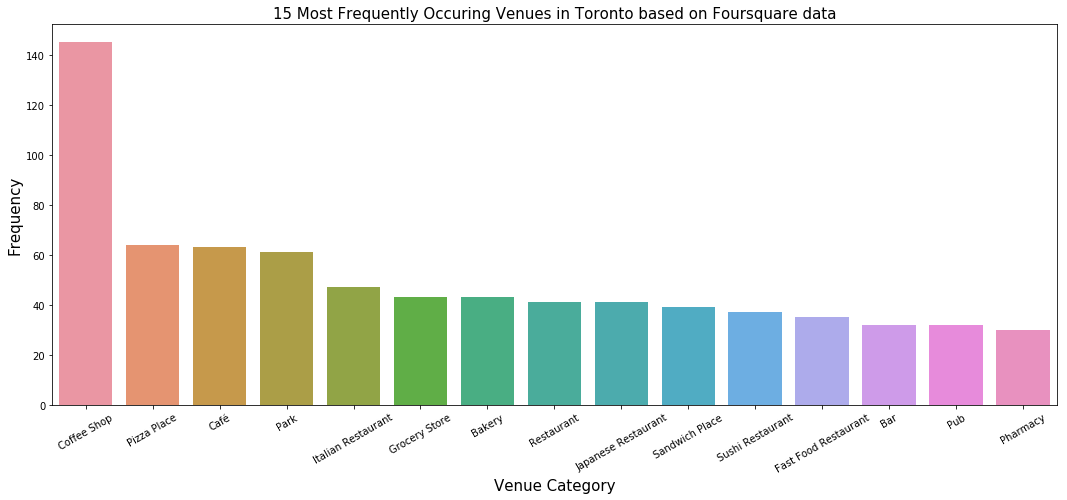

In [37]:
#Top 15 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=Toronto_Venues_Top15)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('15 Most Frequently Occuring Venues in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()

In [38]:
print(Toronto_venues.shape)
Toronto_venues.head(20)

(1948, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Summerhill Market,43.686265,-79.375458,Grocery Store
1,Rosedale-Moore Park,43.679563,-79.377529,Toronto Lawn Tennis Club,43.680667,-79.388559,Athletics & Sports
2,Rosedale-Moore Park,43.679563,-79.377529,Black Camel,43.677016,-79.389367,BBQ Joint
3,Rosedale-Moore Park,43.679563,-79.377529,Craigleigh Gardens,43.678099,-79.371586,Park
4,Rosedale-Moore Park,43.679563,-79.377529,Pie Squared,43.672143,-79.377856,Pie Shop
5,Rosedale-Moore Park,43.679563,-79.377529,Tinuno,43.671281,-79.374920,Filipino Restaurant
6,Rosedale-Moore Park,43.679563,-79.377529,Starbucks,43.671478,-79.380664,Coffee Shop
7,Rosedale-Moore Park,43.679563,-79.377529,Manulife Financial,43.672070,-79.382449,Office
8,Rosedale-Moore Park,43.679563,-79.377529,Booster Juice,43.671566,-79.378581,Smoothie Shop
9,Rosedale-Moore Park,43.679563,-79.377529,Aroma Espresso Bar,43.672154,-79.377885,Coffee Shop


In [39]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Agincourt North,Milliken",29,29,29,29,29,29
"Annex,Casa Loma",100,100,100,100,100,100
Banbury-Don Mills,31,31,31,31,31,31
Bay Street Corridor,100,100,100,100,100,100
"Bayview Village,Bayview Woods-Steeles",15,15,15,15,15,15
"Bedford Park-Nortown,Lawrence Park North",37,37,37,37,37,37
Birchcliffe-Cliffside,16,16,16,16,16,16
Church-Yonge Corridor,100,100,100,100,100,100
Clairlea-Birchmount,31,31,31,31,31,31


In [40]:
#All Restaurant venues that contain Restaurant or BBQ on their category name
Toronto_restaurants = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant|BBQ')].reset_index(drop=True)
print(Toronto_restaurants.shape)
Toronto_restaurants.head()

(504, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Black Camel,43.677016,-79.389367,BBQ Joint
1,Rosedale-Moore Park,43.679563,-79.377529,Tinuno,43.671281,-79.374920,Filipino Restaurant
2,Rosedale-Moore Park,43.679563,-79.377529,Nijo Japanese Restaurant,43.671849,-79.378824,Japanese Restaurant
3,Rosedale-Moore Park,43.679563,-79.377529,Caribbean Taste,43.671898,-79.378105,Caribbean Restaurant
4,Kingsway South,43.653654,-79.506944,"Ma Maison, Boulangerie - Patisserie - Traiteur",43.659490,-79.513624,French Restaurant


In [41]:
#count number of restaurants for each neighbourhood
TNR_count=Toronto_restaurants.groupby('Neighborhood').count()
TNR_count['Venue Category']

Neighborhood
Agincourt North,Milliken                                                        12
Annex,Casa Loma                                                                 31
Banbury-Don Mills                                                                8
Bay Street Corridor                                                             24
Bayview Village,Bayview Woods-Steeles                                            4
Bedford Park-Nortown,Lawrence Park North                                        13
Birchcliffe-Cliffside                                                            4
Church-Yonge Corridor                                                           35
Clairlea-Birchmount                                                              4
Corso Italia-Davenport                                                           6
Don Valley Village                                                               8
East End-Danforth                                                         

In [42]:
# create a dataframe of top 10 restaurants categories
TNR_Top10 = Toronto_restaurants['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
TNR_Top10=TNR_Top10.reset_index()

TNR_Top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
TNR_Top10.head()


,Venue Category,Frequency
0,Italian Restaurant,47
1,Japanese Restaurant,41
2,Restaurant,41
3,Sushi Restaurant,37
4,Fast Food Restaurant,35


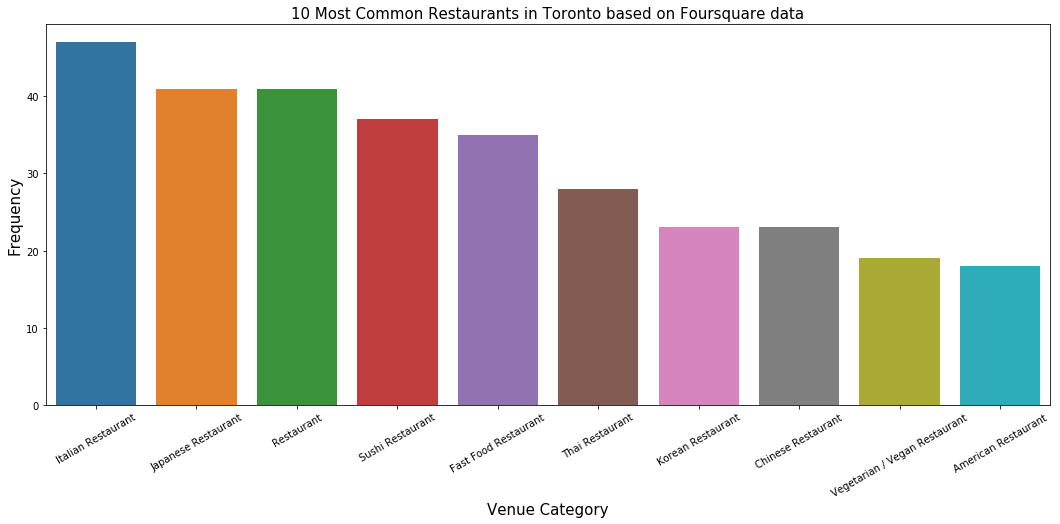

In [43]:

#Top 10 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=TNR_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Common Restaurants in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()


In [44]:
#Japanese Restaurant venues that contain Sushi or Japanese or Ramen on their category name
Toronto_Japanese_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Sushi|Japanese|Ramen')].reset_index(drop=True)
print(Toronto_Japanese_restaurant.shape)
Toronto_Japanese_restaurant.head()

(93, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Nijo Japanese Restaurant,43.671849,-79.378824,Japanese Restaurant
1,Kingsway South,43.653654,-79.506944,Momiji Sushi Bar & Grill,43.647843,-79.508534,Sushi Restaurant
2,Kingsway South,43.653654,-79.506944,Sushi 2 Go,43.647875,-79.509427,Sushi Restaurant
3,Leaside-Bennington,43.709060,-79.363452,Kintako Japanese Restaurant,43.711597,-79.363962,Sushi Restaurant
4,Leaside-Bennington,43.709060,-79.363452,Maki Sushi,43.710127,-79.362466,Sushi Restaurant


In [45]:
#count number of japanese restaurants for each neighbourhood
Toronto_Japanese_restaurant.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Annex,Casa Loma",2,2,2,2,2,2
Banbury-Don Mills,3,3,3,3,3,3
Bay Street Corridor,6,6,6,6,6,6
"Bayview Village,Bayview Woods-Steeles",2,2,2,2,2,2
"Bedford Park-Nortown,Lawrence Park North",2,2,2,2,2,2
Church-Yonge Corridor,10,10,10,10,10,10
Corso Italia-Davenport,1,1,1,1,1,1
Don Valley Village,2,2,2,2,2,2
East End-Danforth,4,4,4,4,4,4


In [46]:
#Return locations with less than 3 Japanese restaurant
TN_JR=Toronto_Japanese_restaurant.groupby('Neighborhood').count()
TN_JR1=TN_JR[TN_JR['Venue Category']<3]
TN_JR1['Venue Category']

Neighborhood
Annex,Casa Loma                             2
Bayview Village,Bayview Woods-Steeles       2
Bedford Park-Nortown,Lawrence Park North    2
Corso Italia-Davenport                      1
Don Valley Village                          2
Eglinton East                               1
Kingsway South                              2
Rosedale-Moore Park                         1
South Riverdale                             2
York University Heights                     2
Name: Venue Category, dtype: int64

In [47]:
#Create the list of business it exclude restaurants and BBQ joints
Toronto_business = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Bank|Mall|Coffee|Café|Pizza|Cafe|Pharmacy|Storage|Tea|Grocery|Store|pub|Historic|Gym|Studio|Building|Shop|Museum|Plaza|Gallery|Business|Pub|Bar|Office|Theater')].reset_index(drop=True)
print(Toronto_business.shape)
Toronto_business.head()

(918, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Summerhill Market,43.686265,-79.375458,Grocery Store
1,Rosedale-Moore Park,43.679563,-79.377529,Pie Squared,43.672143,-79.377856,Pie Shop
2,Rosedale-Moore Park,43.679563,-79.377529,Starbucks,43.671478,-79.380664,Coffee Shop
3,Rosedale-Moore Park,43.679563,-79.377529,Manulife Financial,43.672070,-79.382449,Office
4,Rosedale-Moore Park,43.679563,-79.377529,Booster Juice,43.671566,-79.378581,Smoothie Shop


In [48]:
#count number of business for each restaurant
TNB_count=Toronto_business.groupby('Neighborhood').count()
TNB_count['Venue Category']

Neighborhood
Agincourt North,Milliken                                                        10
Annex,Casa Loma                                                                 47
Banbury-Don Mills                                                               13
Bay Street Corridor                                                             53
Bayview Village,Bayview Woods-Steeles                                            6
Bedford Park-Nortown,Lawrence Park North                                        16
Birchcliffe-Cliffside                                                            6
Church-Yonge Corridor                                                           45
Clairlea-Birchmount                                                             13
Corso Italia-Davenport                                                          11
Don Valley Village                                                              29
East End-Danforth                                                         

In [49]:
#create a list with number of business greater than 10
TNB=TNB_count[TNB_count['Venue']>10]
TNB['Venue']

Neighborhood
Annex,Casa Loma                                    47
Banbury-Don Mills                                  13
Bay Street Corridor                                53
Bedford Park-Nortown,Lawrence Park North           16
Church-Yonge Corridor                              45
Clairlea-Birchmount                                13
Corso Italia-Davenport                             11
Don Valley Village                                 29
East End-Danforth                                  43
Forest Hill South                                  36
High Park North,High Park-Swansea,Junction Area    50
Kingsway South                                     23
Lansing-Westgate,Willowdale East                   48
Leaside-Bennington                                 36
Mount Pleasant East,Mount Pleasant West            45
Palmerston-Little Italy                            50
Parkwoods-Donalda                                  15
Roncesvalles                                       43
Rosedale-Moore 

In [50]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 256 uniques categories.


In [51]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Zoo,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Noodle House,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale-Moore Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [52]:
Toronto_onehot.shape

(1948, 256)

In [53]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Zoo,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Noodle House,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Agincourt North,Milliken",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.068966,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.034483,0.00,0.0,0.0,0.206897,0.0,0.0,0.0,0.0,0.00,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.034483,0.000000,0.0,0.

In [54]:
Toronto_grouped.shape

(42, 256)

Print the top 10 most common venues for each selected neighbourhood based on their popularity

In [55]:
num_top_venues = 10
for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North,Milliken----
                venue  freq
0  Chinese Restaurant  0.21
1              Bakery  0.07
2         Pizza Place  0.07
3   Korean Restaurant  0.07
4            Pharmacy  0.07
5        Noodle House  0.07
6                Park  0.07
7      Shop & Service  0.03
8         Event Space  0.03
9    Malay Restaurant  0.03


----Annex,Casa Loma----
                           venue  freq
0                           Café  0.05
1                    Coffee Shop  0.05
2  Vegetarian / Vegan Restaurant  0.05
3                         Bakery  0.04
4             Italian Restaurant  0.04
5                     Restaurant  0.04
6                  Grocery Store  0.03
7                            Pub  0.03
8                            Gym  0.03
9                         Museum  0.03


----Banbury-Don Mills----
                           venue  freq
0            Japanese Restaurant  0.10
1                    Pizza Place  0.06
2                    Coffee Shop  0.06
3                   

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Agincourt North,Milliken",Chinese Restaurant,Pharmacy,Bakery,Pizza Place,Park,Noodle House,Korean Restaurant,Coffee Shop,Caribbean Restaurant,Dessert Shop
1,"Annex,Casa Loma",Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Restaurant,Italian Restaurant,Pub,Museum,Gym,Grocery Store
2,Banbury-Don Mills,Japanese Restaurant,Coffee Shop,Burger Joint,Pizza Place,Salad Place,Basketball Court,Spa,Breakfast Spot,Cafeteria,Sandwich Place
3,Bay Street Corridor,Coffee Shop,Ice Cream Shop,Café,Ramen Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Park,Bubble Tea Shop,Chinese Restaurant,Gym
4,"Bayview Village,Bayview Woods-Steeles",Bank,Grocery Store,Japanese Restaurant,Fast Food Restaurant,Skating Rink,Skate Park,Shopping Mall,Park,Trail,Café


In [58]:
# set number of clusters
kclusters = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([0, 1, 1, 1, 0], dtype=int32)

In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = dfn

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged=Toronto_merged.dropna() # check the last columns!

In [60]:
Toronto_merged['Cluster Labels']=Toronto_merged['Cluster Labels'].astype(int)

In [61]:
 #create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [62]:
Toronto_merged.sort_values('Cluster Labels').reset_index(drop=True)
Toronto_merged.head()

,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529,1,Coffee Shop,Grocery Store,Park,Bank,Office,Candy Store,Caribbean Restaurant,Sandwich Place,Japanese Restaurant,Shopping Mall
1,M4N,Central Toronto,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790,1,College Quad,Coffee Shop,Café,Park,Bus Line,Bookstore,Trail,College Gym,Gym / Fitness Center,Event Space
2,M8X,Etobicoke,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944,1,Coffee Shop,Park,French Restaurant,Burger Joint,Italian Restaurant,Breakfast Spot,Sushi Restaurant,Dessert Shop,Pub,Gourmet Shop
3,M4G,East York,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452,1,Coffee Shop,Sporting Goods Shop,Electronics Store,Furniture / Home Store,Sushi Restaurant,Restaurant,Brewery,Sports Bar,Burger Joint,Grocery Store
4,M4V,Central Toronto,Forest Hill South,10732,2.45,4380,182035.268195,43.686412,-79.400049,1,Coffee Shop,Park,Italian Restaurant,Sushi Restaurant,Pizza Place,Thai Restaurant,Grocery Store,Gym / Fitness Center,Restaurant,Bagel Shop


Cluster 0 Information

In [63]:
dfc1=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[2,3] + list(range(6, Toronto_merged.shape[1]))]]
dfc1.reset_index(drop=True, inplace=True)
dfc1

,Neighbourhood,Population,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Woburn,53485,145933.058584,43.770992,-79.216917,0,Park,Coffee Shop,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Indian Restaurant,Electronics Store,Event Space,Ethiopian Restaurant,Design Studio
1,Parkwoods-Donalda,34805,144639.211442,43.753259,-79.329656,0,Park,Pharmacy,Shopping Mall,Bus Stop,Convenience Store,Skating Rink,Tennis Court,Food & Drink Shop,Café,Supermarket
2,"Eringate-Centennial-West Deane,Islington-City ...",73604,134993.473120,43.650943,-79.554724,0,Park,Pizza Place,Hotel,Bank,Gym,Theater,Grocery Store,Mexican Restaurant,Fish & Chips Shop,Café
3,Stonegate-Queensway,25051,119843.838510,43.636258,-79.498509,0,Italian Restaurant,Park,Shopping Mall,Gym / Fitness Center,Eastern European Restaurant,Ice Cream Shop,Dog Run,Dessert Shop,Diner,Discount Store
4,"Agincourt North,Milliken",55685,110493.664337,43.815252,-79.284577,0,Chinese Restaurant,Pharmacy,Bakery,Pizza Place,Park,Noodle House,Korean Restaurant,Coffee Shop,Caribbean Restaurant,Dessert Shop
5,Edenbridge-Humber Valley,15535,102322.730799,43.667856,-79.532242,0,Pharmacy,Playground,Shopping Mall,Bakery,Café,Baseball Field,Golf Course,Park,Convenience Store,Grocery Store
6,Glenfield-Jane Heights,30491,95121.544626,43.739015,-79.506944,0,Bank,Coffee Shop,Vietnamese Restaurant,Pizza Place,Grocery Store,Spa,Park,Shopping Mall,Dog Run,Dessert Shop
7,Corso Italia-Davenport,14133,70527.081077,43.689026,-79.453512,0,Pharmacy,Mexican Restaurant,Park,Bakery,Thai Restaurant,Market,Fast Food Restaurant,Bus Stop,Sporting Goods Shop,Beer Store
8,"Bayview Village,Bayview Woods-Steeles",34550,70518.961182,43.786947,-79.385975,0,Bank,Grocery Store,Japanese Restaurant,Fast Food Restaurant,Skating Rink,Skate Park,Shopping Mall,Park,Trail,Café
9,"Westminster-Branson,Willowdale West",43210,70267.476459,43.782736,-79.442259,0,Pharmacy,Pizza Place,Bakery,Discount Store,Butcher,Eastern European Restaurant,Park,Bus Line,Convenience Store,Coffee Shop


Cluster 1 Information

In [64]:
dfc2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[2,3] + list(range(6, Toronto_merged.shape[1]))]]
dfc2.reset_index(drop=True, inplace=True)
dfc2

,Neighbourhood,Population,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rosedale-Moore Park,20923,327842.352420,43.679563,-79.377529,1,Coffee Shop,Grocery Store,Park,Bank,Office,Candy Store,Caribbean Restaurant,Sandwich Place,Japanese Restaurant,Shopping Mall
1,Lawrence Park South,15179,282244.042538,43.728020,-79.388790,1,College Quad,Coffee Shop,Café,Park,Bus Line,Bookstore,Trail,College Gym,Gym / Fitness Center,Event Space
2,Kingsway South,9271,208942.045617,43.653654,-79.506944,1,Coffee Shop,Park,French Restaurant,Burger Joint,Italian Restaurant,Breakfast Spot,Sushi Restaurant,Dessert Shop,Pub,Gourmet Shop
3,Leaside-Bennington,16828,195253.063975,43.709060,-79.363452,1,Coffee Shop,Sporting Goods Shop,Electronics Store,Furniture / Home Store,Sushi Restaurant,Restaurant,Brewery,Sports Bar,Burger Joint,Grocery Store
4,Forest Hill South,10732,182035.268195,43.686412,-79.400049,1,Coffee Shop,Park,Italian Restaurant,Sushi Restaurant,Pizza Place,Thai Restaurant,Grocery Store,Gym / Fitness Center,Restaurant,Bagel Shop
5,"Annex,Casa Loma",41494,155187.997998,43.672710,-79.405678,1,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Restaurant,Italian Restaurant,Pub,Museum,Gym,Grocery Store
6,South Riverdale,27876,153733.028955,43.659526,-79.340923,1,Coffee Shop,Bar,Café,Bakery,Vietnamese Restaurant,American Restaurant,Brewery,Italian Restaurant,Diner,French Restaurant
7,Waterfront Communities-The Island,65913,153659.253917,43.644771,-79.373306,1,Coffee Shop,Hotel,Café,Japanese Restaurant,Beer Bar,Bakery,Cocktail Bar,Park,Restaurant,Gastropub
8,The Beaches,21567,152930.551411,43.676357,-79.293031,1,Coffee Shop,Pub,Pizza Place,Breakfast Spot,Beach,Japanese Restaurant,Bar,Tea Room,Restaurant,Park
9,"Bedford Park-Nortown,Lawrence Park North",37843,138167.075770,43.733283,-79.419750,1,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Skating Rink,Sandwich Place,Sports Club,Indian Restaurant,Intersection,Japanese Restaurant,Juice Bar


Cluster 2 Information

In [65]:
dfc3=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[2,3] + list(range(6, Toronto_merged.shape[1]))]]
dfc3.reset_index(drop=True, inplace=True)
dfc3

,Neighbourhood,Population,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,St.Andrew-Windfields,17812,150633.54934,43.75749,-79.374714,2,Park,Pool,Department Store,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
